In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [15]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#### Some helper

In [17]:
from bgflow import (
    DenseNet,
    
    WrapTransformerWithInverse,
    MixtureCDFTransformer,
    AffineSigmoidComponents,
    SmoothRamp,
    BisectionRootFinder,
    
    ConstrainedBoundaryCDFTransformer,
    
    SequentialFlow,
    CouplingFlow,
    SplitFlow,
    InverseFlow,
    SwapFlow
)
    
from toy_data.toy_data import dataset_names, inf_train_gen

from matplotlib.colors import LogNorm


def plot_transformer_density(transformer, label, grid_size=100):
    with torch.enable_grad():
        ys = torch.linspace(0, 1, 100).view(-1, 1).requires_grad_(True)
        xs = torch.zeros_like(ys)
        ys_, dlogp_ = transformer(xs, ys)
        computed_density = dlogp_.exp()
        ad_density = torch.autograd.grad(ys_.sum(), ys, create_graph=True)[0]
        
        plt.figure(figsize=(10, 3))
        plt.title(label)
        plt.plot(ys.detach(), ys_.detach(), label="cdf")
        plt.plot(ys.detach(), computed_density.detach(), alpha=0.5, label="computed pdf")
        plt.plot(ys.detach(), ad_density.detach(), linestyle="--", label="AD pdf")
        plt.legend()
        

def make_transformer(
    d_in,
    d_out,
    d_hidden,
    n_components,
    periodic=False,
    zero_boundary_left=False,
    zero_boundary_right=False,
    activation=torch.nn.SiLU(),
    smoothness_type="type1"
):
    return WrapTransformerWithInverse(
        transformer=MixtureCDFTransformer(
            compute_weights=DenseNet([d_in, d_hidden, d_hidden, d_out * n_components], activation),
            compute_components=AffineSigmoidComponents(
                conditional_ramp=SmoothRamp(
                    compute_alpha=DenseNet([d_in, d_hidden, d_hidden, d_out * n_components], activation),
                    unimodal=True,
                    ramp_type=smoothness_type
                ),
                compute_params=DenseNet([d_in, d_hidden, d_hidden, d_out * (3 * n_components)], activation),
                min_density=torch.tensor(1e-4),
                periodic=periodic,
                zero_boundary_left=zero_boundary_left,
                zero_boundary_right=zero_boundary_right
                
            ),
        ),
        root_finder=BisectionRootFinder(abs_tol=torch.tensor(1e-5), max_iters=100, verbose=True, raise_exception=True)
    )


def make_constrained_transformer(transformer, left_bound=None, right_bound=None,  smoothness_type="type1"):
    def compute_constraints(x):
        bounds = []
        if left_bound is not None:
            bounds.append(torch.tensor([left_bound]).log().expand_as(x))
        if right_bound is not None:
            bounds.append(torch.tensor([right_bound]).log().expand_as(x))
        return torch.stack(bounds, dim=-1)
    
    return ConstrainedBoundaryCDFTransformer(
        transformer=transformer,
        compute_constraints=compute_constraints,
        left_constraint=left_bound is not None,
        right_constraint=right_bound is not None,
        smoothness_type=smoothness_type
    )


def make_coupling_flow(transformer_factory):    
    return SequentialFlow([
        SplitFlow(1),
        CouplingFlow(transformer_factory()),
        SwapFlow(),
        CouplingFlow(transformer_factory()),
        SwapFlow(),
        CouplingFlow(transformer_factory()),
        SwapFlow(),
        CouplingFlow(transformer_factory()),
        SwapFlow(),
        InverseFlow(SplitFlow(1))
    ])

def train(flow, dataset="pinwheel", train_with_inverse=False, batch_size=1_000, learning_rate=1e-3, n_iters=1_000, print_interval=100):
    optim = torch.optim.Adam(flow.parameters(), lr=learning_rate)
    for it in range(n_iters):
        x = (inf_train_gen(dataset, batch_size=batch_size) + 4) / 8
        x = torch.FloatTensor(x) % 1    
        y, dlogp = flow(x, inverse=train_with_inverse)    
        nll = -dlogp.mean()    
        optim.zero_grad()
        nll.backward()
        optim.step()
        if not it % print_interval:            
            print(f"it: {it}/{n_iters}, nll: {nll.item():.4}", end="\r")
            

            
def plot_evaluation(flow, dataset="pinwheel", train_with_inverse=False, n_samples=100_000):
    
    print("Computing energy plot...")
    with torch.no_grad():
        xs = torch.meshgrid(
            torch.linspace(0, 1, 100),
            torch.linspace(0, 1, 100)
        )
        xs = torch.stack(xs, dim=-1).view(-1, 2)
        ys, dlogp = flow(xs, inverse=train_with_inverse)
        u = -dlogp
        u = u.view(100, 100)
        
    norm = LogNorm()
    plt.figure(figsize=(8, 8))
    plt.title("Energy")
    plt.imshow((-u).exp().detach(), norm=norm)
    
    print("Sampling ground truth...")
    norm = LogNorm()
    x = (inf_train_gen(dataset, batch_size=n_samples) + 4) / 8
    x = torch.FloatTensor(x) % 1
    plt.figure(figsize=(8, 8))
    plt.title("Ground truth samples")
    plt.hist2d(*x.detach().numpy().T, bins=100, density=True, norm=norm, range=((0, 1), (0, 1)));
    
    print("Sampling model...")
    norm = LogNorm()
    with torch.no_grad():
        z = torch.rand(n_samples, 2)
        x, _ = flow(z, inverse=not train_with_inverse)
    plt.figure(figsize=(8, 8))
    plt.title("Flow samples")
    plt.hist2d(*x.detach().numpy().T, bins=100, density=True, norm=norm, range=((0, 1), (0, 1)));

## How to create compact transformers

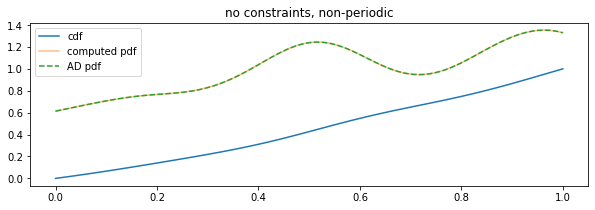

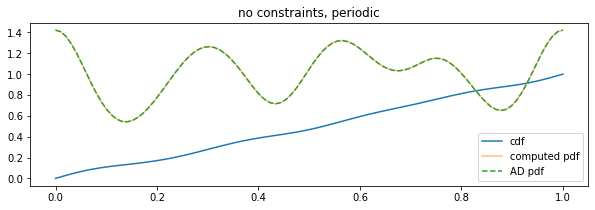

In [18]:
plot_transformer_density(
    make_transformer(d_in=1, d_out=1, d_hidden=40, n_components=4, periodic=False, zero_boundary_left=False, zero_boundary_right=False),
    label="no constraints, non-periodic"
)

plot_transformer_density(
    make_transformer(d_in=1, d_out=1, d_hidden=40, n_components=4, periodic=True, zero_boundary_left=False, zero_boundary_right=False),
    label="no constraints, periodic"
)

## Zero density constraint at boundary

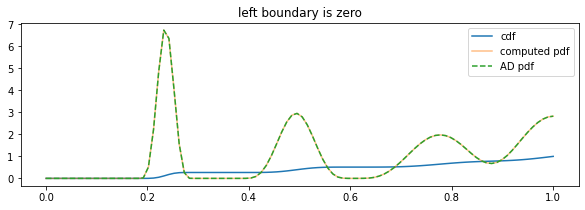

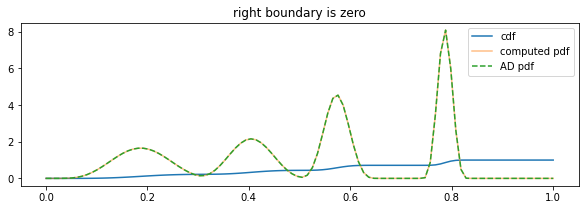

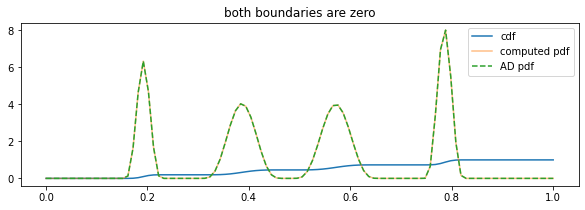

In [19]:
plot_transformer_density(
    make_transformer(d_in=1, d_out=1, d_hidden=40, n_components=4, periodic=False, zero_boundary_left=True, zero_boundary_right=False),
    label="left boundary is zero"
)

plot_transformer_density(
    make_transformer(d_in=1, d_out=1, d_hidden=40, n_components=4, periodic=False, zero_boundary_left=False, zero_boundary_right=True),
    label="right boundary is zero"
)

plot_transformer_density(
    make_transformer(d_in=1, d_out=1, d_hidden=40, n_components=4, periodic=False, zero_boundary_left=True, zero_boundary_right=True),
    label="both boundaries are zero"
)

## Value constraint at boundary

torch.Size([100, 1, 1]) torch.Size([100, 1])


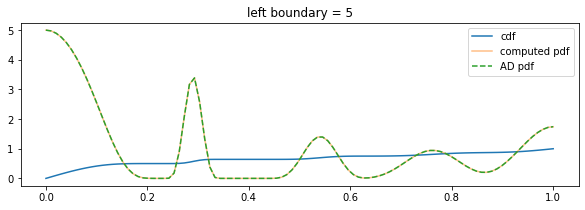

In [20]:
plot_transformer_density(
    make_constrained_transformer(
        make_transformer(d_in=1, d_out=1, d_hidden=40, n_components=4, periodic=False, zero_boundary_left=True, zero_boundary_right=False),
        left_bound=5
    ),
    label="left boundary = 5"
)

torch.Size([100, 1, 1]) torch.Size([100, 1])


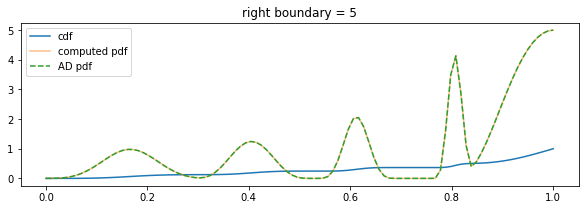

In [21]:
plot_transformer_density(
    make_constrained_transformer(
        make_transformer(d_in=1, d_out=1, d_hidden=40, n_components=4, periodic=False, zero_boundary_left=False, zero_boundary_right=True),
        right_bound=5
    ),
    label="right boundary = 5"
)

torch.Size([100, 1, 2]) torch.Size([100, 1])


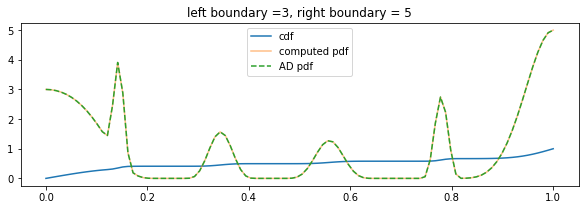

In [22]:
plot_transformer_density(
    make_constrained_transformer(
        make_transformer(d_in=1, d_out=1, d_hidden=40, n_components=4, periodic=False, zero_boundary_left=True, zero_boundary_right=True, smoothness_type="type1"),
        left_bound=3,
        right_bound=5,
        smoothness_type="type1"
    ),
    label="left boundary =3, right boundary = 5"
)

## Density Estimation Example

In [23]:
from functools import partial

flow = make_coupling_flow(partial(make_transformer, d_in=1, d_out=1, d_hidden=200, n_components=20))

In [24]:
for block in flow._blocks:
    if isinstance(block, CouplingFlow):
        block.transformer._root_finder._verbose=True
        print(block.transformer._root_finder._verbose)

True
True
True
True


In [25]:
train(flow)

Computing energy plot...
Sampling ground truth...
Sampling model...
Starting bisection search with abs_tol=1e-05 and 100 iterations.
iteration: 0/100, error: 0.95456
iteration: 1/100, error: 0.9293
iteration: 2/100, error: 0.90683
iteration: 3/100, error: 0.8972
iteration: 4/100, error: 0.57549
iteration: 5/100, error: 0.39775
iteration: 6/100, error: 0.22548
iteration: 7/100, error: 0.11836
iteration: 8/100, error: 0.059673
iteration: 9/100, error: 0.029727
iteration: 10/100, error: 0.014701
iteration: 11/100, error: 0.0073451
iteration: 12/100, error: 0.0036977
iteration: 13/100, error: 0.0018435
iteration: 14/100, error: 0.00091162
iteration: 15/100, error: 0.00044754
iteration: 16/100, error: 0.00021845
iteration: 17/100, error: 0.00010628
iteration: 18/100, error: 4.7743e-05
iteration: 19/100, error: 1.8567e-05
iteration: 20/100, error: 9.9987e-06
Starting bisection search with abs_tol=1e-05 and 100 iterations.
iteration: 0/100, error: 0.73037
iteration: 1/100, error: 0.75983
iter

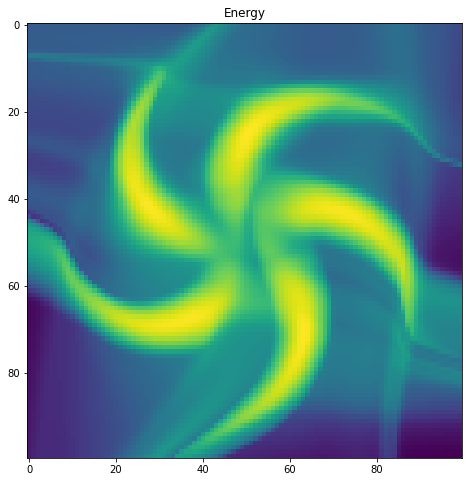

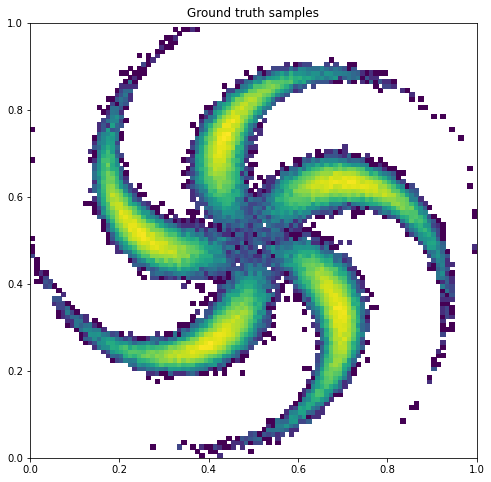

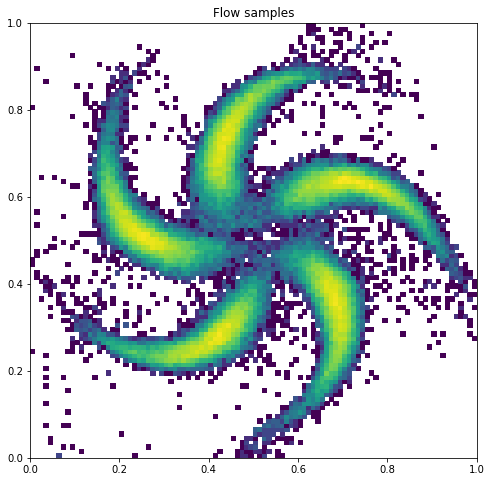

In [26]:
plot_evaluation(flow)

In [44]:
t = make_transformer(d_in=5, d_out=7, d_hidden=200, n_components=20)

x = torch.zeros(1000, 5)
y = torch.linspace(0, 1, 1000).view(1000, 1).repeat(1, 7)

In [45]:
%timeit t(x, y)

16.9 ms ± 853 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
